In [1]:
from collections import Counter, defaultdict
from datasets import load_dataset
import unicodedata
import tiktoken
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import get_dataset_config_names, load_dataset
from transformers import AutoTokenizer
import re

In [2]:
def save_list_to_file(data_list, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        f.writelines(f"{item}\n" for item in data_list)

def load_list_from_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

def save_results_to_file(data_list, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(str(data_list))

In [3]:
######### TOKENIZER #########

In [4]:
import json
import os
import ast

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from collections import defaultdict
from tokenizers.pre_tokenizers import PreTokenizer
from transformers import PreTrainedTokenizerFast

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [5]:
input_file = "_n-gramms-2-3-4-5.txt"
with open(input_file, "r", encoding="utf-8") as f:
    raw_text = f.read()
    ngram_data = ast.literal_eval(raw_text)

In [6]:
n_gramms_intersection_o200k_base_cl100k_base_mistral_tokens_qwen_tokens_qwen_3_tokens = set(load_list_from_file('_n-gramms-intersection.txt'))

In [7]:
output_dir = "_bvv241-abs"
os.makedirs(output_dir, exist_ok=True)
languages =     ["en", "ru", "fr", "de", "zh", "he", "it", "es", "ar", "pt", "ko", "hu", "sa", "la", "ja", "el",     "sv", "nl", "pl", "vi", "fa", "no", "tr", "fi", "cs", "hy", "da", "bn", "az", "ka", "hi", "id"]
top_cnt = 906 #906 is optimal for 2-3-3-4-5-gramms fitting in unused unicod ranges (and > 65535). 1000 for 2-3-4-5   171 for 2-3-4  800 for 2 (bigramms)

UNICODE_LIMIT =   0xD800 # from 0 до D7FF monograms
SURROGATE_START = 0xD800
SURROGATE_END =   0xE000

SPECIAL_TOKENS_START = 0xE000
SPECIAL_TOKENS_LIMIT = SPECIAL_TOKENS_START + 256  # 0xE100 = 57600
NGRAM_START = SPECIAL_TOKENS_LIMIT  # 0xE100 = 57600
NGRAM_LIMIT = 0xF900

VOCAB_SIZE_TARGET = 65536

NGRAM_START_EXT = 0x10000
NGRAM_LIMIT_EXT = 0x1FFFF

VOCAB_SIZE_TARGET = 2 * 65536

In [8]:
vocab = {}

for cp in range(0x0000, UNICODE_LIMIT): 
    try:
        ch = chr(cp)
    except ValueError:
        continue
    if ch not in vocab:
        vocab[ch] = cp

#for cp in range(SURROGATE_START, SURROGATE_END):
#    vocab[f"<surrogate_{cp}>"] = cp

special_tokens = [
    "<pad>", "<s>", "</s>", "<unk>", "<think>", "</think>", "<emotions>", "</emotions>", "<tool_call>", "</tool_call>", "<tool_response>", "</tool_response>", "[INST]", "[/INST]", "[EOT]", "[USER]", "[ASSISTANT]", "[FIM_PREFIX]", "[FIM_MIDDLE]", "[FIM_SUFFIX]", "[FIM_PAD]", "[REPO_NAME]", "[FILE_SEP]"
]
for i, tok in enumerate(special_tokens):
    vocab[tok] = SPECIAL_TOKENS_START + i

for cp in range(SPECIAL_TOKENS_START + len(special_tokens), SPECIAL_TOKENS_LIMIT):
    vocab[f"<special_token_{cp}>"] = cp

for cp in range(NGRAM_LIMIT, 0xFFFF): 
    try:
        ch = chr(cp)
    except ValueError:
        continue
    if ch not in vocab:
        vocab[ch] = cp

In [9]:
len(vocab)

57343

In [10]:
ngram_set = set()
for entry in ngram_data:
    if entry["lang"] not in languages:
        continue
    top_ngrams = entry["top_ngrams"]
    for n in sorted(top_ngrams.keys(), reverse=True):  # 5 → 2
        top_list = top_ngrams[n][:top_cnt]
        for gram, _ in top_list:
            ngram_set.add(gram)

In [11]:
len(ngram_set)

59955

In [12]:
ngram_list = list(n_gramms_intersection_o200k_base_cl100k_base_mistral_tokens_qwen_tokens_qwen_3_tokens)

ngram_list = [ng for ng in ngram_list if len(ng) > 1]

ngram_list_sorted = sorted(ngram_list, key=len)

selected_ngrams = set(ngram_list_sorted[0:65536])

ngram_new = ngram_set.union(selected_ngrams)

In [13]:
ngram_set = ngram_new

In [14]:
len(ngram_set)

73768

In [15]:
next_id = SURROGATE_START
added_ng = []
for ng in sorted(ngram_set, key=lambda x: (-len(x), x)): 
    vocab[ng] = next_id
    added_ng.append(ng)
    next_id += 1
    if next_id >= SURROGATE_END:
        print('SURROGATE_END next_id=',SURROGATE_START, SURROGATE_END, next_id)
        break

SURROGATE_END next_id= 55296 57344 57344


In [16]:
len(vocab)

59391

In [17]:
next_id = NGRAM_START
for ng in sorted(ngram_set, key=lambda x: (-len(x), x)): 
    if ng not in added_ng:
        vocab[ng] = next_id
        added_ng.append(ng)
        next_id += 1
        if next_id >= NGRAM_LIMIT:
            print('NGRAM_LIMIT next_id=',NGRAM_START, NGRAM_LIMIT, next_id)
            break

NGRAM_LIMIT next_id= 57600 63744 63744


In [18]:
print(NGRAM_LIMIT - next_id)

0


In [19]:
len(vocab)

65535

In [20]:
next_id = NGRAM_START_EXT
for ng in sorted(ngram_set, key=lambda x: (-len(x), x)):  
    if ng not in added_ng:
        vocab[ng] = next_id
        added_ng.append(ng)
        next_id += 1
        if next_id >= NGRAM_LIMIT_EXT:
            print('NGRAM_LIMIT_EXT next_id=',NGRAM_START_EXT, NGRAM_LIMIT_EXT, next_id)
            break
            
print(NGRAM_LIMIT_EXT - next_id)
print(len(vocab))

NGRAM_LIMIT_EXT next_id= 65536 131071 131071
0
131070


In [21]:
used_ids = set(vocab.values())
for fill_id in range(0, VOCAB_SIZE_TARGET):
    if fill_id not in used_ids:
        vocab[f"<unused_{fill_id}>"] = fill_id

In [22]:
len(vocab)

131072

In [23]:
def generate_merges_from_ngrams(vocab, ngram_set):
    merges = []
    for piece in sorted(ngram_set, key=lambda x: (-len(x), x)):
        if piece not in vocab:
            continue
        i = 1
        while i <= len(piece):
            left = piece[:i]
            right = piece[i:]
            if left in vocab and right in vocab:
                merges.append((left, right))
                #break
            i += 1
    return merges

In [24]:
merges = generate_merges_from_ngrams(vocab, ngram_set)

In [25]:
len(merges)

182678

In [26]:
os.makedirs(output_dir, exist_ok=True)

tokenizer = Tokenizer(BPE(vocab=vocab, merges=merges, unk_token="<unk>"))
tokenizer.pre_tokenizer = None             
tokenizer.decoder = decoders.Sequence([])  
tokenizer.post_processor = None            
tokenizer.add_special_tokens(special_tokens)
tokenizer.save(os.path.join(output_dir, "tokenizer.json"))

with open(os.path.join(output_dir, "merges.txt"), "w", encoding="utf-8") as f:
    for m in merges:
        f.write(f"{m[0]} {m[1]}\n")

with open(os.path.join(output_dir, "vocab.txt"), "w", encoding="utf-8") as f:
    for token, idx in sorted(vocab.items(), key=lambda x: x[1]):
        f.write(f"{idx:>6} | {repr(token):<12} | len={len(token)}\n")

with open(os.path.join(output_dir, "vocab.json"), "w", encoding="utf-8") as f:
    json.dump({k: v for k, v in sorted(vocab.items(), key=lambda x: x[1])},
              f, indent=2, ensure_ascii=False)

with open(os.path.join(output_dir, "tokenizer_config.json"), "w") as f:
    json.dump({
        "model_type": "gpt2",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "<unk>",
        "pad_token": "<pad>",
        "vocab_size": 131072
    }, f, indent=2)

with open(os.path.join(output_dir, "special_tokens_map.json"), "w") as f:
    json.dump({
        "unk_token": "<unk>",
        "pad_token": "<pad>",
        "bos_token": "<s>",
        "eos_token": "</s>"
    }, f, indent=2)

with open(os.path.join(output_dir, "special_tokens_map.json"), "w") as f:
    json.dump({
        "model_type": "PreTrainedTokenizerFast",
          "model_type": "gpt2",
          "bos_token": "<s>",
          "eos_token": "</s>",
          "unk_token": "<unk>",
          "pad_token": "<pad>",
          "vocab_size": 131072
    }, f, indent=2)

with open(os.path.join(output_dir, "config.json"), "w") as f:
    json.dump({
        "model_type": "gpt2",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "<unk>",
        "pad_token": "<pad>",
        "vocab_size": 131072
    }, f, indent=2)

In [27]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from IPython.display import display
import unicodedata
import math
import random
import numpy as np

In [28]:
#https://en.wikipedia.org/wiki/GNU_Unifont

''' GNU Unifont is a free Unicode bitmap font created by Roman Czyborra. The main Unifont covers all of the Basic Multilingual Plane (BMP) '''

In [29]:
#we use unifont-14.0.01.ttf for embeddings

In [ ]:
!wget -q https://ftp.gnu.org/gnu/unifont/unifont-14.0.01/unifont-14.0.01.ttf

In [30]:
font_size = 64                     
glyph_size = (64, 64)              
font = ImageFont.truetype('unifont-14.0.01.ttf', font_size)
random.seed(42)
np.random.seed(42)

In [31]:
def describe_char(c):
    print(f"symbol: {c}")
    print(f"ord: U+{ord(c):04X}")
    print(f"name: {unicodedata.name(c, 'UNKNOWN')}")
    print(f"category: {unicodedata.category(c)}")
    print(f"Bidirectional: {unicodedata.bidirectional(c)}")
    print(f"Combining: {unicodedata.combining(c)}")
    print(f"Decomposition: {unicodedata.decomposition(c)}")
    print(f"Mirrored: {unicodedata.mirrored(c)}")
    print(f"Decimal value: {unicodedata.decimal(c, '—')}")
    print(f"isprintable: {c.isprintable()}")
    print(f"isspace: {c.isspace()}")
    print(f"isalpha: {c.isalpha()}")
    print(f"isupper?: {c.isupper()}") 
    print(f"islower?: {c.islower()}") 
    print(f"Title-case?: {c.istitle()}")

In [32]:
def is_complex_script(s):
    complex_keywords = ['CJK', 'ARABIC', 'HEBREW', 'DEVANAGARI', 'BENGALI', 'THAI', 'KANNADA', 'TAMIL', 'TELUGU', 'KHMER', 'MYANMAR', 'SINHALA', 'SYRIAC']
    for c in s:
        name = unicodedata.name(c, '')
        if any(kw in name for kw in complex_keywords):
            return True
    return False

In [33]:
def is_easy_script(s):
    for c in s:
        code = ord(c)
        if not (
            (0x0000 <= code <= 0x007F) or  # Basic Latin
            (0x0080 <= code <= 0x00FF) or  # Latin-1 Supplement
            (0x0100 <= code <= 0x024F) or  # Latin Extended A/B
            (0x0370 <= code <= 0x03FF) or  # Greek and Coptic
            (0x0400 <= code <= 0x04FF) or  # Cyrillic
            (0x0500 <= code <= 0x052F) or  # Cyrillic Supplement
            (0x0530 <= code <= 0x058F)     # Armenian
        ):
            return False  
    return True

In [34]:
def image_to_bitlist_row_major(img):
    bw = img.convert('1')  
    pixels = bw.load()
    width, height = bw.size
    bits = [0] * (width * height)
    for y in range(height):
        for x in range(width):
            bits[y * width + x] = 0 if pixels[x, y] else 1
    return bits

In [35]:
def image_to_bitlist_polar_snake(img):
    bw = img.convert('1')
    pixels = bw.load()
    width, height = bw.size
    cx, cy = width / 2, height / 2
    coords = []

    for y in range(height):
        for x in range(width):
            dx = x - cx
            dy = y - cy
            r = math.hypot(dx, dy)
            theta = math.atan2(dy, dx)
            coords.append((r, theta, x, y))

    coords.sort()  
    bitlist = []
    for r, theta, x, y in coords:
        value = 0 if pixels[x, y] else 1
        bitlist.append(value)
    return bitlist

In [36]:
def augment_image(img, chars):
    is_complex = not is_easy_script(chars)

    random.seed(42)
    np.random.seed(42)
    
    max_rotation = 0 if is_complex else 7
    max_shift = 0 if is_complex else 3
    noise_level = 0.001 if is_complex else 0.03
    apply_blur = False if is_complex else True

    angle = random.uniform(-max_rotation, max_rotation)
    img = img.rotate(angle, expand=0, fillcolor=255)

    dx = random.randint(-max_shift, max_shift)
    dy = random.randint(-max_shift, max_shift)
    shifted = Image.new("L", img.size, color=255)
    shifted.paste(img, (dx, dy))
    img = shifted

    np_img = np.array(img)

    noise_mask = np.random.rand(*np_img.shape) < noise_level
    np_img[noise_mask] = 0  

    img = Image.fromarray(np_img)
    if apply_blur:
        img = img.filter(ImageFilter.GaussianBlur(radius=0.5))

    bw = img.point(lambda p: 0 if p < 128 else 255, mode='1') 
    return bw

64 64


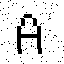

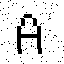

64 128


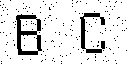

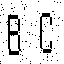

In [37]:
images=[]
for text in ['A', 'BC']:#, '꧄']
    img_width = glyph_size[0] * len(text)
    img_height = glyph_size[1]
    img = Image.new("L", (img_width, img_height), color=255)
    draw = ImageDraw.Draw(img)

    for i, char in enumerate(text):
        try:
            bbox = font.getbbox(char)
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            x = i * glyph_size[0] + (glyph_size[0] - w) // 2
            y = (glyph_size[1] - h) // 2 - bbox[1]
            draw.text((x, y), char, fill=0, font=font)
        except Exception as e:
            print(f"Error '{char}': {e}")
            pass

    
    print(img_height,img_width)
    
    img_aug = augment_image(img, text)
    images.append(img_aug)
    display(img_aug)
    snake_bits = image_to_bitlist_polar_snake(img_aug)

    img_aug = img_aug.resize((64, 64), Image.BILINEAR) #LANCZOS)
    display(img_aug)    
    reduced = image_to_bitlist_polar_snake(img_aug)

In [38]:
describe_char('1') #'꧄')

symbol: 1
ord: U+0031
name: DIGIT ONE
category: Nd
Bidirectional: EN
Combining: 0
Decomposition: 
Mirrored: 0
Decimal value: 1
isprintable: True
isspace: False
isalpha: False
isupper?: False
islower?: False
Title-case?: False


In [39]:
with open(os.path.join(output_dir, "embeddings_abs.txt"), "w", encoding="utf-8") as f:
    for token, idx in sorted(vocab.items(), key=lambda x: x[1]):
        text = token
        img_width = glyph_size[0] * len(text)
        img_height = glyph_size[1]
        img = Image.new("L", (img_width, img_height), color=255)
        draw = ImageDraw.Draw(img)

        for i, char in enumerate(text):
            try:
                bbox = font.getbbox(char)
                w = bbox[2] - bbox[0]
                h = bbox[3] - bbox[1]
                x = i * glyph_size[0] + (glyph_size[0] - w) // 2
                y = (glyph_size[1] - h) // 2 - bbox[1]
                draw.text((x, y), char, fill=0, font=font)
            except Exception as e:
                print(f"Error '{char}': {e}")
                pass
                
        img_aug = augment_image(img, text)
        
        if img_aug.size != (64, 64):
            img_aug = img_aug.resize((64, 64), Image.BILINEAR)
            
        snake_bits = image_to_bitlist_polar_snake(img_aug)
        
        f.write(f"{idx}\n")   
        f.write(f"{str(snake_bits)}\n") 

In [40]:
def load_binary_file_np(filename):
    data = []
    with open(filename, 'r') as f:
        while True:
            index_line = f.readline()
            if not index_line:
                break
            list_line = f.readline()
            bits = np.fromstring(list_line.replace('[','').replace(']','').strip(), dtype=int, sep=',')
            if bits.size != 4096:
                print(index_line)
                print(list_line)
                raise ValueError("Invalid bit list length")
            data.append(bits)
    return np.array(data, dtype=np.uint8)

In [41]:
data_embeddings = load_binary_file_np(os.path.join(output_dir, "embeddings_abs.txt"))

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [43]:
def apply_pca(data, n_components=4096):
    pca = PCA(n_components=4096)
    transformed = pca.fit_transform(data)
    return transformed, pca

In [44]:
data_embeddings_pca, _pca = apply_pca(data_embeddings.astype(np.float32))

In [45]:
normalized_embeddings = normalize(data_embeddings_pca, norm='l2', axis=1)

In [46]:
import torch

In [47]:
tensor_normalized_embeddings_weights = torch.tensor(normalized_embeddings, dtype=torch.float32)
torch.save(tensor_normalized_embeddings_weights, os.path.join(output_dir, "normalized_embeddings_weights.pt"))

In [48]:
from transformers import AutoTokenizer

In [49]:
tokenizer = AutoTokenizer.from_pretrained(output_dir) 
tokenizer.is_fast

True

In [50]:
ids = tokenizer.encode('hello the test')

In [51]:
print(ids)

[70960, 32, 113757, 32, 99060]


In [52]:
print(tokenizer.decode(ids))

hello the test
